# Diorama TFA multiple Inversions

This notebook performs the inversion using Levenberg-Marquadt's algorithm of total field anomaly (TFA).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pickle
import os
import pandas as pd

from fatiando.vis import mpl

/home/leonardo/anaconda2/lib/python2.7/site-packages/fatiando/vis/mpl.py:76: UserWarning: This module will be removed in v0.6. We recommend the use of matplotlib.pyplot module directly. Some of the fatiando specific functions will remain.
  "specific functions will remain.")


In [2]:
from datetime import date
today = date.today()
# dd/mm/YY
d4 = today.strftime("%b-%d-%Y")

### Auxiliary functions

In [3]:
import sys
sys.path.insert(0, '../../code')

import mag_polyprism_functions as mfun

# Input

### Importing Diorama TFA data

In [4]:
data = pd.read_csv('diorama_decimated_tfa_residual.txt', skipinitialspace=True, delim_whitespace=True)

In [5]:
data['GPSALT'] = data['GPSALT']

In [6]:
xp = data['X'].get_values()
yp = data['Y'].get_values()
zp = data['GPSALT'].get_values()
dobs = data['mag_res2'].get_values()

In [7]:
np.max(zp)

-2.3999999999999773

### Importing Diorama upward TFA data

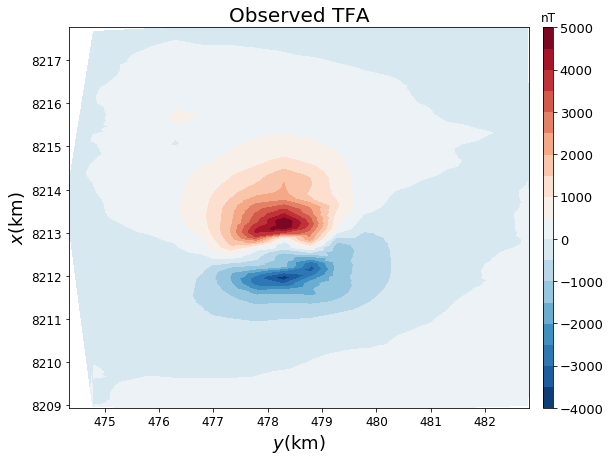

In [8]:
plt.figure(figsize=(10,7))
plt.title('Observed TFA', fontsize=20)
plt.tricontourf(yp, xp, dobs, 20, cmap='RdBu_r').ax.tick_params(labelsize=12)
#plt.plot(data['Y'], data['X'], 'k.')
plt.xlabel('$y$(km)', fontsize=18)
plt.ylabel('$x$(km)', fontsize=18)
clb = plt.colorbar(pad=0.025, aspect=40, shrink=1)
clb.ax.tick_params(labelsize=13)
#estimate = mpl.polygon(model0[0], '.-r', xy2ne=True)
#estimate.set_label('Initial estimate')
clb.ax.set_title('nT')
mpl.m2km()
plt.show()

### Parameters of the initial model

In [9]:
M = 20 # number of vertices per prism
L = 6 # number of prisms
P = L*(M+2) + 1 # number of parameters

# daiana
incs = -46.
decs = 24.

int_min = 12.
int_max = 21.
intensity = np.linspace(int_min, int_max, 10)

# depth to the top, thickness and radius
z0_min = 0.
z0_max = 450.
z0 = np.linspace(z0_min, z0_max, 10)
dz = 350.
r = 1200.

x0, y0 = [8212500., 478200.]

# main field
inc, dec = [-19.5, -18.]

In [10]:
z0

array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.])

In [11]:
intensity

array([12., 13., 14., 15., 16., 17., 18., 19., 20., 21.])

### Limits

In [12]:
# limits for parameters in meters
rmin = 10.
rmax = 1500.
x0min = 8212500.
x0max = 8213500.
y0min = 478000.
y0max = 479000.
dzmin = 10.
dzmax = 1000.

mmin, mmax = mfun.build_range_param(M, L, rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax)

### Variation

In [13]:
# variation for derivatives
deltax = 0.01*np.max(100.)
deltay = 0.01*np.max(100.)
deltar = 0.01*np.max(100.)
deltaz = 0.01*np.max(100.)

### Outcropping parameters

In [14]:
# outcropping body parameters
m_out = np.zeros(M + 2)
#m_out = model['param_vec'][:M+2]

### Regularization parameters

In [15]:
#lamb = th*0.01 # Marquadt's parameter
lamb = 10.0
dlamb = 10.      # step for Marquadt's parameter

a1 = 1.0e-5  # adjacent radial distances within each prism
a2 = 1.0e-6   # vertically adjacent radial distances
a3 = 0.     # outcropping cross-section
a4 = 0.     # outcropping origin
a5 = 1.0e-5    # vertically adjacent origins
a6 = 1.0e-8   # zero order Tikhonov on adjacent radial distances
a7 = 1.0e-6     # zero order Tikhonov on thickness of each prism

In [16]:
delta = np.array([deltax, deltay, deltar, deltaz])
alpha = np.array([a1, a2, a3, a4, a5, a6, a7])

In [17]:
itmax = 30
itmax_marq = 10
tol = 1.0e-4     # stop criterion

In [18]:
foldername = '56586'

### Inversion

In [19]:
inversion_results = []
for j, z in enumerate(z0):
    for k, i in enumerate(intensity):
        alpha = np.array([a1, a2, a3, a4, a5, a6, a7])
        print 'inversion: %d  top: %d  intensity: %2.f' % (j*z0.size + k, z, i)
        model0, m0 = mfun.initial_cylinder(M, L, x0, y0, z, dz, r, inc, dec, incs, decs, i)
        d_fit, m_est, model_est, phi_list, model_list, res_list = mfun.l1_levmarq_tf(
            xp, yp, zp, m0, M, L, delta,
            itmax, itmax_marq, lamb,
            dlamb, tol, mmin, mmax,
            m_out, dobs, inc, dec,
            model0[0].props, alpha, z, dz
        )
        inversion_results.append([m_est, phi_list, model_list, dobs - d_fit])

inversion: 0  top: 0  intensity: 12
it:  0   it_marq:  0   lambda: 1e+01   init obj.: 2.75031e+02  fin obj.: 2.77356e+02
it:  0   it_marq:  1   lambda: 1e+02   init obj.: 2.75031e+02  fin obj.: 2.91955e+02
it:  0   it_marq:  2   lambda: 1e+03   init obj.: 2.75031e+02  fin obj.: 2.94911e+02
it:  0   it_marq:  3   lambda: 1e+04   init obj.: 2.75031e+02  fin obj.: 2.95235e+02
it:  0   it_marq:  4   lambda: 1e+05   init obj.: 2.75031e+02  fin obj.: 2.95268e+02
it:  0   it_marq:  5   lambda: 1e+06   init obj.: 2.75031e+02  fin obj.: 2.95271e+02
it:  0   it_marq:  6   lambda: 1e+07   init obj.: 2.75031e+02  fin obj.: 2.95271e+02
it:  0   it_marq:  7   lambda: 1e+08   init obj.: 2.75031e+02  fin obj.: 2.95271e+02
it:  0   it_marq:  8   lambda: 1e+09   init obj.: 2.75031e+02  fin obj.: 2.95277e+02
it:  0   it_marq:  9   lambda: 1e+10   init obj.: 2.75031e+02  fin obj.: 2.75986e+02
it:  1   it_marq:  0   lambda: 1e+11   init obj.: 2.75031e+02  fin obj.: 2.75991e+02
it:  1   it_marq:  1   lambda

# Results

In [20]:
inversion = dict()

In [21]:
inversion['x'] = xp
inversion['y'] = yp
inversion['z'] = zp
inversion['observed_data'] = dobs

In [22]:
inversion['x'].size

1230

In [23]:
inversion['inc_dec'] = [incs, decs]
inversion['z0'] = z0
inversion['initial_dz'] = dz
inversion['initial_r'] = r
inversion['limits'] = [rmin, rmax, x0min, x0max, y0min, y0max, dzmin, dzmax]
inversion['regularization'] = np.array([a1, a2, a3, a4, a5, a6, a7])
inversion['tol'] = tol
inversion['main_field'] = [inc, dec]
inversion['intensity'] = intensity

### Folder to save the results

In [24]:
if foldername == '':
    mypath = 'l1-tfa-inversion/multiple-'+d4 #default folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)
else:
    mypath = 'l1-tfa-inversion/multiple-'+foldername #defined folder name
    if not os.path.isdir(mypath):
       os.makedirs(mypath)

In [25]:
inversion['results'] = inversion_results

In [26]:
file_name = mypath+'/inversion.pickle'
with open(file_name, 'w') as f:
    pickle.dump(inversion, f)

In [27]:
mypath

'l1-tfa-inversion/multiple-56586'

##### 